# The N-Queens Problem

The following works gives a simple solver for the [N-Queens Problem](https://en.wikipedia.org/wiki/Eight_queens_puzzle). We represent the board as a [constraint satisfaction problem](https://en.wikipedia.org/wiki/Constraint_satisfaction_problem) and find a valid solution using the [backtracking algorithm](https://en.wikipedia.org/wiki/Backtracking). That no two queens can be in the same diagonal, row or column are the constraints to enforce. We represent these constraints in [SymPy](http://www.sympy.org/en/index.html), a light-weight computer algebra system written in Python.

The backtracking algorithm retains a partial set of assignments of queens to squares, checking, at each assignment, whether all stipulated constraints hold. If so, it continues in recursive fashion, initiating the next step with the current assignment set. If not, it "backtracks:" the most recent assignment is undone, and the algorithm explores other assignments in turn. The backtracking algorithm can be further improved by strategies like forward-checking, intelligent value-ordering, etc. These are not implemented here.

Finally, this works builds off of code from [Udacity's Artificial Intelligence Nanodegree](https://github.com/udacity/AIND-Constraint_Satisfaction).

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from util import constraint, displayBoard
from sympy import symbols, init_printing, Ne
from IPython.display import display
init_printing()
%matplotlib inline

## Declare variables

In [7]:
first_queen_row = symbols('first\_queen\_row')
second_queen_row = symbols('second\_queen\_row')
first_queen_col = symbols('first\_queen\_col')
second_queen_col = symbols('second\_queen\_col')

## Declare constraints

In [8]:
diffRow = constraint('diffRow', Ne(first_queen_row, second_queen_row))
diffDiag = constraint('diffDiag', Ne( abs(first_queen_row - second_queen_row), abs(first_queen_col - second_queen_col) ))

## Test constraints

In [9]:
assert(len(diffRow.free_symbols) == 2)
assert(diffRow.subs({first_queen_row: 0, second_queen_row: 1}) == True)
assert(diffRow.subs({first_queen_row: 0, second_queen_row: 0}) == False)
assert(diffRow.subs({first_queen_row: 0}) != False)
print("Passed diffRow tests.")

Passed diffRow tests.


In [10]:
diffDiag_test = diffDiag.subs({first_queen_row: 1, second_queen_row: 3})

assert(len(diffDiag_test.free_symbols) == 2)
assert(diffDiag_test.subs({first_queen_col: 0, second_queen_col: 2}) == False)
assert(diffDiag_test.subs({first_queen_col: 0, second_queen_col: 0}) == True)
assert(diffDiag_test.subs({first_queen_col: 0}) != False)
print("Passed diffDiag tests.")

Passed diffDiag tests.


## N-Queens CSP

In [11]:
class NQueensCSP:

    def __init__(self, N):
        _vars = [symbols('queen_{}'.format(i)) for i in range(N)]
        _domain = set(range(N))
        self.size = N
        self.variables = _vars
        self.domains = {v: _domain for v in _vars}
        self._constraints = {queen: set() for queen in _vars}
        for queen in _vars:
            other_queens = [other_queen for other_queen in _vars if other_queen != queen]

            for other_queen in other_queens:    
                self._constraints[queen].update(
                    set([
                        diffRow.subs({
                            first_queen_row: queen, 
                            second_queen_row: other_queen
                        }),
                        diffDiag.subs({
                            first_queen_row: queen, 
                            second_queen_row: other_queen,
                            first_queen_col: int(queen.name[-1]),
                            second_queen_col: int(other_queen.name[-1])
                        })
                    ])
                )
    
    @property
    def constraints(self):
        constraints = set()
        for _cons in self._constraints.values():
            constraints |= _cons
        return list(constraints)
    
    def is_complete(self, assignment):
        return set( assignment.values() ) == set( range(self.size) )
    
    def is_consistent(self, var, value, assignment):
        queen = var
        for other_queen in assignment:
            for constraint in self._constraints[queen]:
                if not constraint.subs({queen: value, other_queen: assignment[other_queen]}):
                    return False
        return True
        
    def inference(self, var, value):
        return {}
    
    def show(self, assignment):
        locations = [(i, assignment[j]) for i, j in enumerate(self.variables)
                     if assignment.get(j, None) is not None]
        displayBoard(locations, self.size)

## Backtracking search

In [12]:
def select(csp, assignment):
    for var in csp.variables:
        if var not in assignment:
            return var
    return None

def order_values(var, assignment, csp):
    return csp.domains[var]

def backtracking_search(csp):
    return backtrack({}, csp)

def backtrack(assignment, csp):
    if csp.is_complete(assignment):
        return assignment
    var = select(csp, assignment)
    
    for value in order_values(var, assignment, csp):
        if csp.is_consistent(var, value, assignment):
            assignment[var] = value
            inferences = csp.inference(var, value)
            if inferences is not None:
                assignment.update(inferences)
                result = backtrack(assignment, csp)
                if result:
                    return result
        assignment.pop(var, None)
    return None

## Solve

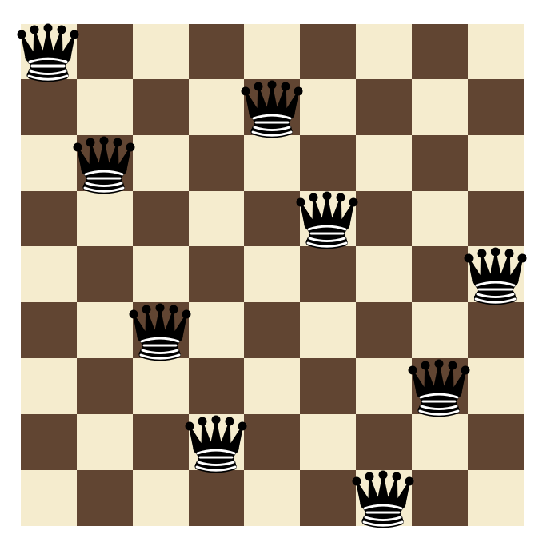

Solution found:
{queen_0: 0, queen_1: 2, queen_2: 5, queen_3: 7, queen_4: 1, queen_5: 3, queen_6: 8, queen_7: 6, queen_8: 4}


In [13]:
num_queens = 9
csp = NQueensCSP(num_queens)
assignment = backtracking_search(csp)

if assignment is not None:
    csp.show(assignment)
    print("Solution found:\n{!s}".format(assignment))
else:
    print("No solution found.")